<a href="https://colab.research.google.com/github/ShaiShmuel/fake_news_detection/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fake news detaction by title | Uriel Bender & Shai Shmuel**

In [3]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import keras
import matplotlib.pyplot as plt

# **Reading the Data set**

In [4]:
Train_data = pd.read_csv('/content/sample_data/train.csv', error_bad_lines=False)
Train = Train_data.copy()


In [5]:
#printing first 15 lines of our train dataset
Train[0:15]

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


#**Feature Statistics**

In [6]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [7]:
Train.shape

(20800, 5)

In [8]:
#checking if there is null values
Train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [9]:
Train.count()

id        20800
title     20242
author    18843
text      20761
label     20800
dtype: int64

##all the null titles that we removed were tagged as not fake

In [10]:
df1 = Train[Train['title'].isna()]
print(df1.label.value_counts())

1    558
Name: label, dtype: int64


In [11]:
#Drop all null values only in the title feature
Train = Train.dropna(subset=['title'])

In [12]:
#confirming there isn't any null values that left
Train.isnull().sum()

id           0
title        0
author    1957
text        39
label        0
dtype: int64

In [13]:
Train[0:9]

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0


**We can see that we have missing values in our training set, id 6 and 8 are missing**

In [14]:
news_type = pd.crosstab(Train.label, Train.title)
news_type

title,"""Allahu Akbar, the Russians are here!"": Aleppo terrorists flee Russian airstrike (VIDEO)","""Authoritarianism"": How the West demonizes strong, popular leaders","""Blue Alerts"" to be used to keep the 'War on Cops' lie, alive","""Democracy Is Coming to the USA"" - Russia News Now","""Donald, willst du mich heiraten?"": Clinton hat Kampf ums Weiße Haus noch nicht aufgegeben","""Dont Criticize what you cannot Understand"" Mr. Kejriwal watch this video of Gurumurthy, its a perfect answer to you!","""Europe Has No Future"" Putin Slams Austria Migrant Child Rape Injustice","""Fake News"" About Trump Continues Unabated","""France First"" – Le Pen Hits Out At Islamism and Globalisation","""Hamilton"" Actor Refuses To Apologize For Political Stunt","""Just say it's the Russians"" - Joaquin Flores on RT [Video]","""Top Five Clinton Donors Are Jewish"" - How Anti-Semitic Is This Fact?","""Zu unseriös"": Auch Lothar Matthäus sagt HSV als Sportdirektor ab","""В ""гиперзвуке"" Россия на передовых позициях, у США такого пока нет""","""Гражданам мира"" нужно не Отечество, а собственное спокойствие""","""Для Порошенко главные ветераны войны — бандеровцы""","""Надеюсь, инициаторы создания памятника Петлюре об этом пожалеют""","""Реакция Венгрии на сюжет Киселева это не угроза России""","""Собрал наглость в кулак и назвался писателем""","""Чем ближе мы к взятию Алеппо, тем яростнее Россию будут обвинять""",#2816: Clinton Pride’s 8(a) Pig Farm Bridge – Serco Zulu Server Snuff –Soros's Patented Voter Key,#2817: Serco's Zulu Starnet Blackmail – Clinton 8(a) Pig Farm Bridge – Soros Patent Vote,#2820: Clinton 8(a) Pig Farm Servers – Boeing Bridge Of Pimps – Serco In-Flight Zulu Snuff,#BREAKING: SECOND Assassination Attempt On Trump In NV; Suspect Detained (LIVE BLOG),#BREAKING: TRUMP USHERED OFF STAGE IN NV SUSPECT DETAINED,#BoycottComedian…ROBERT DENIRO Wanted “To Punch Trump In The Face”…Supports Anti-Trump Rioters…Now Wants Americans To Support His New Movie [VIDEO],#DraftOurDaughters: Feminist Hillary Supporters Vow To Fight War With Russia For Us,#DraftOurDaughters: Pro-War Hillary Faces Backlash Over Female Draft,#GrammysSoWhite Came to Life. Will the Awards Face Its Race Problem? - The New York Times,#InNorthDakota ~~ PALESTINIANS STAND WITH THE SIOUX,#MayorsStand4All Day Touts Support for Illegal Immigrants,#MyUnintendedJoy: Americans Show Why They Choose Life Over Abortion - Breitbart,"#NDDL: Pour fêter l’autorisation des travaux, Manuel Valls détruit personnellement plusieurs hectares de zone humide >> Le Gorafi",#NODAPL: Battle at the End of the World,#NoDAPL Situation Critical,#NoDAPL Spills Over: Musicians Boycott Dakota Access Pipeline CEO’s Record Label & Festival,#NoDAPL: Angry Man Fires 7 Shots Into Air Near Standing Rock Water Protectors,#Podesta21: Clinton’s ‘Twisted’ Behavior ‘Smacks of Acting Above the Law’,#PodestaEmails20: WikiLeaks releases another batch from Clinton campaign chair,#ProtestPP: Nationwide Protests Against Government Funding of Planned Parenthood Underway - Breitbart,...,"“National Mood” Focus Group Reflects Angry, Divided America",“Not A ‘Real’ Union”: Emails Show Clinton Campaign Attacks On Nurses,“Nothing Good Can Come of This Election”–and That’s Good,“Notre batal a coulé” par l’homme qui fait des blagues douteuses même pendant un naufrage >> Le Gorafi,“Organic” Food From China Found To Be Highly Contaminated,“People Power” Versus Manipulation of the Masses,“Regime Change”? South Africa Targeted by Western Destabilization Efforts? | Global Research,“Rigged To Deny Trump”: Are They Stealing These States to Block Electoral Path to 270?,“Rigged To Deny Trump”: Looks Like Elite Trying to Steal These States to Block Electoral Path to 270,“Scary Stories In 5 Words” are terrifying tales for people short on time,“Sex Shop Kierkegaard: punto de encuentro para amantes del placer intelectual”,“Shoot First Ask Questions Later” : What Happens To A UFO When Tracked on Military Radar,"“Sometimes Bill And Hillary 

In [15]:
#checking how many labels = 0 and how many = 1
Train.count()

id        20242
title     20242
author    18285
text      20203
label     20242
dtype: int64

**We want to check if all of our titles and texts have a reasonable length (how many chars there are in each title and text)**

In [16]:
lengthttl,lengthtxt = [],[]

#Title
[lengthttl.append(len(str(title))) for title in Train['title']]
Train['title-length'] = lengthttl

#Same for the text
[lengthtxt.append(len(str(text))) for text in Train['text']]
Train['text-length'] = lengthtxt
Train.head()

,id,title,author,text,label,title-length,text-length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,81,4930
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,55,4160
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,33,7692
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,63,3237
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,93,938


In [17]:
min(Train['title-length']), max(Train['title-length']), round(sum(Train['title-length'])/len(Train['title-length']))

(3, 456, 74)

In [18]:
def get_outliers(df, series):
  q1 = series.quantile(0.25)
  q3 = series.quantile(0.75)

  if q1*q3 == 0:
    iqr = abs(2*(q1+q3))
    toprange = iqr
    botrange = -toprange
  else:
    iqr = q3-q1
    toprange = q3 + iqr * 1.5
    botrange = q1 - iqr * 1.5

  outliers_top=df[series > toprange]
  outliers_bot= df[series < botrange]
  outliers = pd.concat([outliers_bot, outliers_top], axis=0)

  return (botrange, toprange, outliers)

In [19]:
botrange, toprange, outliers = get_outliers(Train, Train['title-length'])
print(toprange)
print(botrange)
outliers

130.0
18.0


,id,title,author,text,label,title-length,text-length
86,86,Poison,Heather Callaghan,By Dr. Mark Sircus Everyone knows that there a...,1,6,202
248,248,The Left’s Vision,Thomas Sowell,"By Thomas Sowell November 1, 2016 \nThe politi...",1,17,4391
257,257,Newsticker (974),noreply@blogger.com (Der Postillon),+++ Hände weg vom Alkohol: Schreiner rührt nac...,1,16,772
563,563,Coming Unglued,John Kaminski,"By John Kaminski on October 30, 2016 John Kami...",1,14,11039
877,877,WWN’s Horoscopes,Gerry McBride,aries 21 March – 20 April \nDoes the ‘5 second...,1,16,1284
...,...,...,...,...,...,...,...
20223,20223,Comment on Understanding Misleading Food Label...,Understanding Misleading Food Labels: An Infog...,Share on Facebook Share on Twitter “Let food b...,1,277,3675
20277,20277,"Like a good little sharia-compliant female, Pr...",BareNakedIslam,BNI Store Nov 6 2016 Like a good little sharia...,1,165,830
20324,20324,THE END GAME closes in on the Clintons as the ...,Dave Hodges,THE END GAME closes in on the Clintons as the ...,1,188,10103
20513,20513,SAID IN SPANISH: A Mexican Governor Meddles In...,Allan Wall,,1,156,1


In [20]:
fig = go.Figure()
fig.add_trace(go.Box(name='Title length', y=Train['title-length'], boxmean='sd'))

fig.update_traces(
    marker=dict(
        color='rgb(8,81,156)',
        outliercolor='rgba(219, 64, 82, 0.6)',
        line=dict(
            outliercolor='rgba(219, 64, 82, 0.6)',
            outlierwidth=2)),
    line_color='rgb(8,81,156)'
)
fig.show()

In [21]:
Train.shape

(20242, 7)

In [22]:
len(Train[Train['title-length'] < 18])


129

In [23]:
len(Train[Train['title-length'] > 130])


247

Same process with our text length

In [24]:
botrange, toprange, outliers = get_outliers(Train, Train['text-length'])
print(toprange)
print(botrange)
outliers

13283.375
-5187.625


,id,title,author,text,label,title-length,text-length
14,14,"Re: Yes, There Are Paid Government Trolls On S...",AnotherAnnie,"Yes, There Are Paid Government Trolls On Socia...",1,85,34204
29,29,How Hillary Clinton Became a Hawk - The New Yo...,Mark Landler,Hillary Clinton sat in the hideaway study off ...,0,54,38806
36,36,Re: Why We Are Still In ‘The Danger Zone’ Unti...,greanfinisher .,Why We Are Still In ‘The Danger Zone’ Until Ja...,1,66,20807
37,37,Open Thread (NOT U.S. Election) 2016-39,b,Open Thread (NOT U.S. Election) 2016-39 \nNews...,1,39,18950
71,71,Treason! NYT vows 'rededication' to reporting!,Ivan the Stakhanovets,"In Hillary's America, email server scrubs you ...",1,46,27696
...,...,...,...,...,...,...,...
20658,20658,Comment on 5 Corporations Own The U.S. Media –...,You’re Being Fooled: The Problem With ‘Alterna...,"From the day we are born into this world, we...",1,205,24954
20662,20662,The Truth U.S. Government Does NOT Want You To...,Dikran Arakelian (noreply@blogger.com),Share on Facebook The people of the world shou...,1,74,14247
20742,20742,It Begins! Ten Kushner Scandals: Media Ramp Up...,Tony Lee,If Jared Kushner did not realize that the esta...,0,102,18178
20744,20744,The Battleship Debate,Michael Shrimpton,"By Michael Shrimpton on October 30, 2016 Some ...",1,21,18004


In [25]:
fig = go.Figure()
fig.add_trace(go.Box(name='Text length', y=Train['text-length'], boxmean='sd'))

fig.update_traces(
    marker=dict(
        color='rgb(8,81,156)',
        outliercolor='rgba(219, 64, 82, 0.6)',
        line=dict(
            outliercolor='rgba(219, 64, 82, 0.6)',
            outlierwidth=2)),
    line_color='rgb(8,81,156)'
)
fig.show()

In [26]:
len(Train[Train['text-length'] < 128])


282

In attempt to get more accurate data, we will drop data with too long/short title, and too short(less then 128 chars) texts

In [27]:
Train.shape

(20242, 7)

In [28]:
Train.drop(Train[Train['title-length'] > 130].index, inplace = True)
Train.drop(Train[Train['title-length'] < 18].index, inplace = True)
Train.drop(Train[Train['text-length'] < 128].index, inplace = True)
#Train.drop(Train[Train['text-length'] > 10000].index, inplace = True)


In [29]:
Train.shape

(19598, 7)

#**Word** **Cloud**

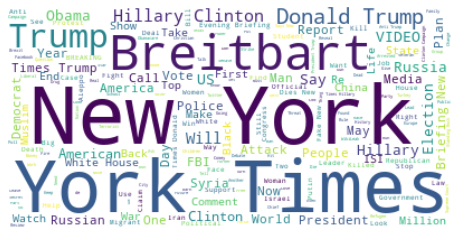

In [30]:
from wordcloud import WordCloud

title = " ".join([x for x in Train.title])

wordcloud = WordCloud(background_color='white').generate(title)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

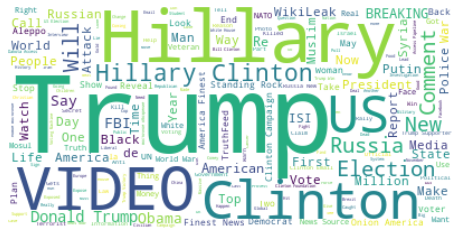

In [31]:
## for fake

title = " ".join([x for x in Train.title[Train.label==1]])

wordcloud = WordCloud(background_color='white').generate(title)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

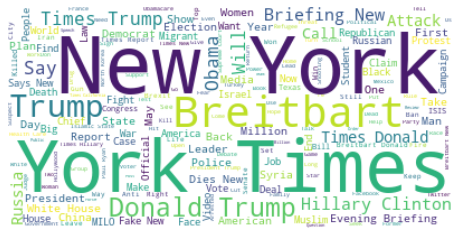

In [32]:
## for real

title = " ".join([x for x in Train.title[Train.label==0]])

wordcloud = WordCloud(background_color='white').generate(title)

plt.figure(figsize=(8,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

**Checking if all of our relevent data is written in English, the function check the ASCII value for each char, if the value is grather then or equal to 128 we will mark the value as non English**

In [33]:
def isEnglish(s):
  if all(ord(c) < 128 for c in s):
    return 1
  else :
    return 0
print(isEnglish("is English?"))

1


In [34]:

isEnglishttl = []
#Mark all non English titles
[isEnglishttl.append(isEnglish(str(title))) for title in Train['title']]
Train['title-English'] = isEnglishttl
#Count non English titles
len(Train[Train['title-English'] == False])


7623

In [35]:
Train[:15]

,id,title,author,text,label,title-length,text-length,title-English
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,81,4930,0
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,55,4160,1
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,33,7692,1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,63,3237,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,93,938,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,124,1192,1
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,110,2729,0
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,87,4923,0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,104,8177,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0,93,10261,1


##we can see that all the non-English title are balanced by thier lables (approx. 50%)

In [36]:
df2 = Train[Train['title-English'] == 1]
print(df2.label.value_counts())

1    5991
0    5984
Name: label, dtype: int64


In [37]:
Train.drop(Train[Train['title-English'] == False].index, inplace = True)
Train.drop(labels=['title-English'], axis=1,inplace=True)
Train.shape


(11975, 7)

In [38]:
pd.set_option("display.precision", 3)
corr_df = Train.corr()
corr_df

,id,label,title-length,text-length
id,1.000,0.002,-0.004,-0.010
label,0.002,1.000,-0.347,-0.109
title-length,-0.004,-0.347,1.000,0.027
text-length,-0.010,-0.109,0.027,1.000


In [39]:
fig = go.Figure(data=go.Heatmap(
                   z=corr_df,
                   x=corr_df.index,
                   y=corr_df.index,
                   zmax=1,
                   zmin=-1,
                   hoverongaps = False))
fig.show()

In [40]:
#max_features = 10000

## Tokenizing the text - converting the words, letters into counts or numbers. 


In [41]:
# We dont need to explicitly remove the punctuations. we have an inbuilt option in Tokenizer for this purpose
# importing neural network libraries
import string
import nltk
import re
from nltk.stem import PorterStemmer
from string import punctuation


# stems words such as plurals (not that accurate)
ps = PorterStemmer()

def preprocess(title):

    title = re.sub("[^a-zA-Z]", " ", title)
    title = title.lower().split()
    title = [ps.stem(word) for word in title]
    title = " ".join(title)
    title = "".join(p for p in title if p not in punctuation)
    
    return title

Train["title-after"] = Train['title'].apply(preprocess)

In [42]:
Train[:15]

,id,title,author,text,label,title-length,text-length,title-after
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,55,4160,flynn hillari clinton big woman on campu breit...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,33,7692,whi the truth might get you fire
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,63,3237,civilian kill in singl us airstrik have been i...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,93,938,iranian woman jail for fiction unpublish stori...
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,124,1192,jacki mason hollywood would love trump if he b...
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0,93,10261,a back channel plan for ukrain and russia cour...
11,11,"BBC Comedy Sketch ""Real Housewives of ISIS"" Ca...",Chris Tomlinson,The BBC produced spoof on the “Real Housewives...,0,58,3132,bbc comedi sketch real housew of isi caus outrag
13,13,US Officials See No Link Between Trump and Russia,Jason Ditz,Clinton Campaign Demands FBI Affirm Trump's Ru...,1,49,1618,us offici see no link between trump and russia
14,14,"Re: Yes, There Are Paid Government Trolls On S...",AnotherAnnie,"Yes, There Are Paid Government Trolls On Socia...",1,85,34204,re ye there are paid govern troll on social me...
15,15,"In Major League Soccer, Argentines Find a Home...",Jack Williams,Guillermo Barros Schelotto was not the first A...,0,79,6403,in major leagu soccer argentin find a home and...


In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ')
tokenizer.fit_on_texts(texts  = Train['title-after'])
X = tokenizer.texts_to_sequences(texts  = Train['title-after'])

In [44]:
# now applying padding to make them even shaped.
X = pad_sequences(sequences = X, maxlen = len(tokenizer.word_index) + 1, padding = 'pre')

In [45]:
print(X.shape)
y = Train['label'].values
print(y.shape)
num_words = len(tokenizer.word_index) + 1
print(num_words)
#tokenizer.word_index

(11975, 10950)
(11975,)
10950


**classify our data like we learn on chollet IMDB reviews model**

In [46]:
# splitting the data training data for training and validation.
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [47]:
import numpy as np

def vectorize_sequences(sequences, dimension=num_words):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(X_train)
# Our vectorized test data
x_test = vectorize_sequences(X_test)

In [48]:
x_train[0]

array([1., 1., 1., ..., 0., 0., 0.])

In [49]:
# Our vectorized labels
y_train = np.asarray(Y_train).astype('float32')
y_test = np.asarray(Y_test).astype('float32')

Keras implementation

In [50]:

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(num_words,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

Configure our model with the rmsprop optimizer and the binary_crossentropy loss function

In [51]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


We are passing our optimizer, loss function and metrics as strings

In [52]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [53]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

### Validating our approach
we will create a "validation set" by setting apart 3,000 samples from the original training data

In [54]:
x_val = x_train[:3000]
partial_x_train = x_train[3000:]

y_val = y_train[:3000]
partial_y_train = y_train[3000:]

We will now train our model for 20 epochs

In [55]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
13/13 [==============================] - 2s 59ms/step - loss: 0.6783 - binary_accuracy: 0.5803 - val_loss: 0.6204 - val_binary_accuracy: 0.8197
Epoch 2/20
13/13 [==============================] - 0s 33ms/step - loss: 0.6006 - binary_accuracy: 0.8138 - val_loss: 0.5344 - val_binary_accuracy: 0.9070
Epoch 3/20
13/13 [==============================] - 1s 46ms/step - loss: 0.5156 - binary_accuracy: 0.8853 - val_loss: 0.4516 - val_binary_accuracy: 0.9183
Epoch 4/20
13/13 [==============================] - 0s 33ms/step - loss: 0.4341 - binary_accuracy: 0.9116 - val_loss: 0.3779 - val_binary_accuracy: 0.9237
Epoch 5/20
13/13 [==============================] - 0s 33ms/step - loss: 0.3595 - binary_accuracy: 0.9297 - val_loss: 0.3138 - val_binary_accuracy: 0.9267
Epoch 6/20
13/13 [==============================] - 0s 33ms/step - loss: 0.2959 - binary_accuracy: 0.9420 - val_loss: 0.2634 - val_binary_accuracy: 0.9297
Epoch 7/20
13/13 [==============================] - 0s 33ms/step - los

In [56]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

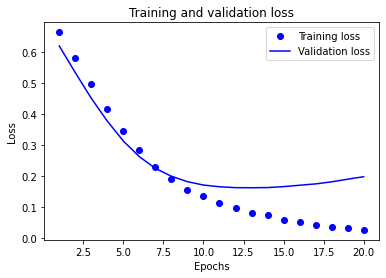

In [57]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

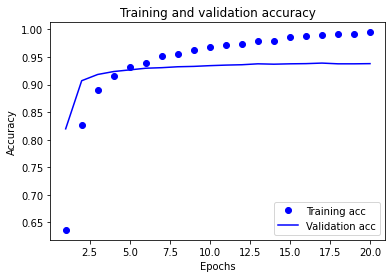

In [58]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Let's train a new network from scratch for four epochs, then evaluate it on our test data:



In [59]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(num_words,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
19/19 [==============================] - 1s 26ms/step - loss: 0.6701 - accuracy: 0.6801
Epoch 2/4
19/19 [==============================] - 0s 26ms/step - loss: 0.5506 - accuracy: 0.8765
Epoch 3/4
19/19 [==============================] - 0s 25ms/step - loss: 0.4368 - accuracy: 0.9088
Epoch 4/4
75/75 [==============================] - 0s 1ms/step - loss: 0.2624 - accuracy: 0.9411


In [60]:
results


[0.26238951086997986, 0.941127359867096]

In [61]:
model.predict(x_test)


array([[0.80915266],
       [0.6377336 ],
       [0.57810265],
       ...,
       [0.8530159 ],
       [0.60824686],
       [0.07629648]], dtype=float32)

In [62]:
len(x_train)

9580